In [ ]:
# Run extraction script%run extract_model_and_images.py

In [ ]:
# Extract test images for deploymentimport osfrom PIL import Imageimport numpy as np# Create test images directorytest_dir = '../test_images'os.makedirs(test_dir, exist_ok=True)# Extract 4 test images (2 with helmet, 2 without)# Use test set images to avoid data leakagehelmet_indices = np.where(y_test == 1)[0][:2]  # First 2 helmet imagesno_helmet_indices = np.where(y_test == 0)[0][:2]  # First 2 no-helmet imagesprint("Extracting helmet images...")for i, idx in enumerate(helmet_indices):    img_array = X_test[idx]    # Denormalize from [0,1] to [0,255]    img = Image.fromarray((img_array * 255).astype('uint8'))    img_path = f'{test_dir}/helmet_{i}.jpg'    img.save(img_path)    print(f"  ✅ Saved: helmet_{i}.jpg (label: {y_test[idx]})")print("\nExtracting no-helmet images...")for i, idx in enumerate(no_helmet_indices):    img_array = X_test[idx]    img = Image.fromarray((img_array * 255).astype('uint8'))    img_path = f'{test_dir}/no_helmet_{i}.jpg'    img.save(img_path)    print(f"  ✅ Saved: no_helmet_{i}.jpg (label: {y_test[idx]})")print(f"\n✅ Extracted 4 test images to: {test_dir}")print(f"  - 2 helmet images: helmet_0.jpg, helmet_1.jpg")print(f"  - 2 no-helmet images: no_helmet_0.jpg, no_helmet_1.jpg")

In [ ]:
# Save trained Model 4import osfrom tensorflow.keras.models import load_modelmodel_path = '../model/helmet_detection_model_v1.keras'model_4.save(model_path)print(f"✅ Model saved to: {model_path}")# Verify loadingloaded_model = load_model(model_path)print("✅ Model loaded successfully!")print(f"Model size: {os.path.getsize(model_path) / (1024*1024):.1f} MB")

# **Problem Statement**

## Business Context

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## Objective

As a data scientist at SafeGuard Corp, you are tasked with developing an `image classification model` that classifies images into one of two categories:- **With Helmet:** Workers wearing safety helmets.- **Without Helmet:** Workers not wearing safety helmets.

## Data Description

The dataset consists of **631 images**, equally divided into two categories:- **With Helmet:** 311 images showing workers wearing helmets.- **Without Helmet:** 320 images showing workers not wearing helmets.**Dataset Characteristics:**- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [7]:
#!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [8]:
import tensorflow as tfprint("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))print(tf.__version__)

Num GPUs Available: 0
2.19.0


**Note:**- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [9]:
# Libraries for Manipulating Dataimport osimport randomimport numpy as np                 import pandas as pdimport seaborn as snsimport matplotlib.image as mpimg     import matplotlib.pyplot as plt      import math                         import cv2# Tensorflow & Keras - MLimport kerasimport tensorflow as tffrom tensorflow.keras.preprocessing.image import ImageDataGenerator                              # For Data Augmentationfrom tensorflow.keras.models import Sequential                                                   # For Sequential Modelingfrom tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # All layers to build our CNN Modelfrom tensorflow.keras.optimizers import Adam,SGD                                                 # Optimizers for Modelfrom sklearn import preprocessing                                                                # Preprocessing Modulesfrom sklearn.model_selection import train_test_split                                             # For Splitting Datafrom sklearn.metrics import confusion_matrixfrom tensorflow.keras.models import Modelfrom keras.applications.vgg16 import VGG16                                            # Display images using OpenCV#from google.colab.patches import cv2_imshow --> Google # Importing cv2_imshow from google.patches to display imagesimport cv2cv2.__version__# Scikit-Learn - Evaluating ML Performancefrom sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_reportfrom sklearn.metrics import mean_squared_error as mse                            # Ignore Warningsimport warningswarnings.filterwarnings('ignore')

In [10]:
# Set the seed using keras.utils.set_random_seed. This will set:# 1) `numpy` seed# 2) backend random seed# 3) `python` random seed# Set random seed for reproducibility across numpy, tensorflow, and python randomtf.keras.utils.set_random_seed(812)

# **Data Overview**

### Loading the data

In [11]:
# Load the images from .npy fileprojectImages = np.load('../../data/images_proj.npy  # Note: Data files excluded from git') # Load the labels from CSV fileprojectLabels = pd.read_csv('../../data/Labels_proj.csv  # Note: Data files excluded from git') 

In [12]:
# Printing the shapes of the images and labelsprint("# of Images: ",projectImages.shape[0])print("Height/Width: ",projectImages.shape[1],"X", projectImages.shape[2] )print("# of Dimensions: ",projectImages.shape[3], "\n")print("# of Images: ",projectLabels.shape[0])  print("# of Labels: ",projectLabels.shape[1])  

# of Images:  631
Height/Width:  200 X 200
# of Dimensions:  3 

# of Images:  631
# of Labels:  1


# **Exploratory Data Analysis**

### Random Images from Classes & Labels

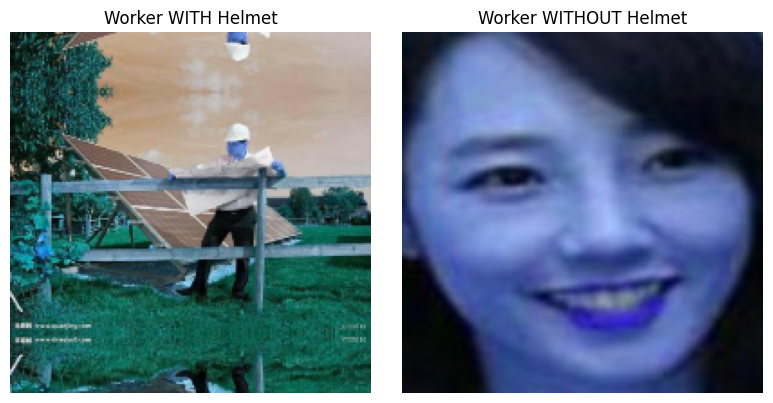

In [13]:
# labels for helmet and non helmetshelmets = np.where(projectLabels == 1)[0]noHelmets = np.where(projectLabels == 0)[0]# select one image from each classhelmetImage = projectImages[np.random.choice(helmets)]noHelmetImage = projectImages[np.random.choice(noHelmets)]# Plot the imagesfig, axes = plt.subplots(1, 2, figsize=(8, 4))# Display "With Helmet" imageaxes[0].imshow(helmetImage)axes[0].set_title("Worker WITH Helmet")axes[0].axis('off')# Display "Without Helmet" imageaxes[1].imshow(noHelmetImage)axes[1].set_title("Worker WITHOUT Helmet")axes[1].axis('off')# Show the plotsplt.tight_layout()plt.show()

### Checking for class imbalance

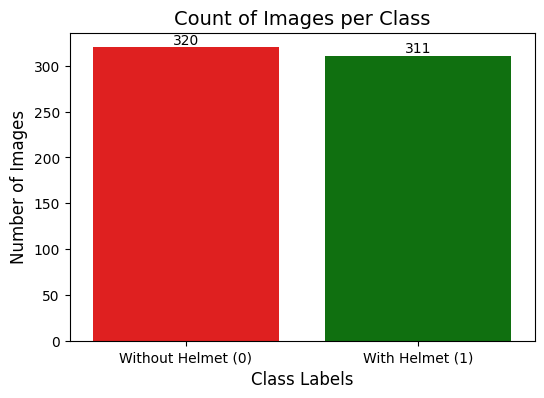

In [14]:
# creating count plot for the datasetplt.figure(figsize=(6, 4))ax = sns.countplot(x=projectLabels.iloc[:, 0], palette=['red', 'green'])# add exact counts on top of barsfor p in ax.patches:    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),                ha='center', va='bottom', fontsize=10, )# add labelsplt.xlabel("Class Labels", fontsize=12)plt.ylabel("Number of Images", fontsize=12)plt.title("Count of Images per Class", fontsize=14)plt.xticks(ticks=[0, 1], labels=["Without Helmet (0)", "With Helmet (1)"])  # Rename x-axis labels# show plotplt.show()

### Insights

- We are displaying random images from the datasets we have, where we can clearly see those with helmets and non-helmets- The graph showcases the counts for each class, which there is no major difference between them, they are almost evenly distributed

# **Data Preprocessing**

### Converting images to grayscale

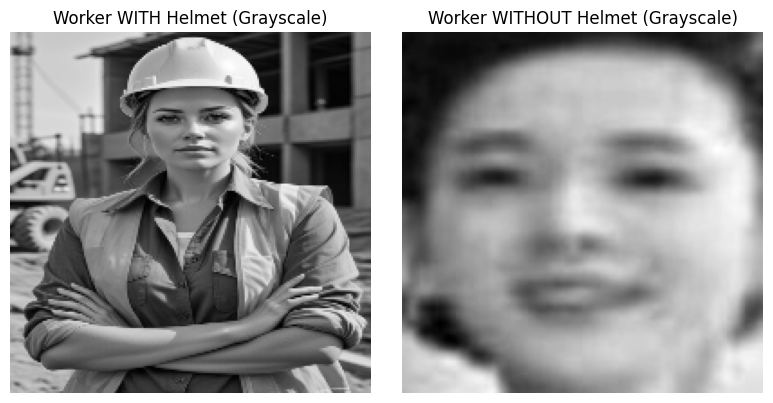

In [15]:
# creating array to input all converted imagesimages_gray = []# looping through images & converting through grayscalefor i in range(len(projectImages)):    img_gray = cv2.cvtColor(projectImages[i], cv2.COLOR_BGR2GRAY)      images_gray.append(img_gray)    # labels for helmet and non helmetshelmets = np.where(projectLabels == 1)[0]noHelmets = np.where(projectLabels == 0)[0]# select one image from each class (grayscale)helmetImage_gray = images_gray[np.random.choice(helmets)]noHelmetImage_gray = images_gray[np.random.choice(noHelmets)]# Plot the grayscale imagesfig, axes = plt.subplots(1, 2, figsize=(8, 4))# Display "With Helmet" grayscale imageaxes[0].imshow(helmetImage_gray, cmap='gray')axes[0].set_title("Worker WITH Helmet (Grayscale)")axes[0].axis('off')# Display "Without Helmet" grayscale imageaxes[1].imshow(noHelmetImage_gray, cmap='gray')axes[1].set_title("Worker WITHOUT Helmet (Grayscale)")axes[1].axis('off')# Show the plotsplt.tight_layout()plt.show()

### Splitting the dataset

In [10]:
# Train SizeX_train, X_temp, y_train, y_temp = train_test_split(np.array(projectImages), projectLabels, test_size=0.3, random_state=42, stratify= projectLabels)# Test SizeX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [11]:
# print the shapes of the train, validation, and test dataprint("X Train: ", X_train.shape, "\ny Train: ", y_train.shape, "\n")print("X Val: ", X_val.shape, "\ny Val: ", y_val.shape, "\n") print("X Test: ", X_test.shape, "\ny Test: ", y_test.shape)

X Train:  (441, 200, 200, 3) 
y Train:  (441, 1) 

X Val:  (95, 200, 200, 3) 
y Val:  (95, 1) 

X Test:  (95, 200, 200, 3) 
y Test:  (95, 1)


### Data Normalization

In [12]:
# Normalize all dataX_train_normalized = X_train.astype('float32')/255 X_val_normalized = X_val.astype('float32')/255  X_test_normalized = X_test.astype('float32')/255 

# **Model Building**

### Utility Functions for Evaluation & Plotting

In [13]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodelsdef model_performance_classification(model, predictors, target):    """    Function to compute different metrics to check classification model performance    model: classifier    predictors: independent variables    target: dependent variable    """    # checking which probabilities are greater than threshold    pred = model.predict(predictors).reshape(-1)>0.5    target = target.to_numpy().reshape(-1)    acc = accuracy_score(target, pred)  # to compute Accuracy    recall = recall_score(target, pred, average='weighted')  # to compute Recall    precision = precision_score(target, pred, average='weighted')  # to compute Precision    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score    # creating a dataframe of metrics    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)    return df_perf

In [14]:
# Plotting the confusion matrix of the modeldef plot_confusion_matrix(model,predictors,target,ml=False):    """    Function to plot the confusion matrix    model: classifier    predictors: independent variables    target: dependent variable    ml: To specify if the model used is an sklearn ML model or not (True means ML model)    """    # checking which probabilities are greater than threshold    pred = model.predict(predictors).reshape(-1)>0.5    target = target.to_numpy().reshape(-1)    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module    confusion_matrix = tf.math.confusion_matrix(target,pred)    f, ax = plt.subplots(figsize=(10, 8))    sns.heatmap(        confusion_matrix,        annot=True,        linewidths=.4,        fmt="d",        square=True,        ax=ax    )    plt.show()

In [15]:
# plotting the accuracy of the modeldef plot_model_accuracy(history):    """    Plot training and validation accuracy from a Keras history object.        Parameters:    history: Keras History object containing training metrics    """    plt.plot(history.history['accuracy'])  # Plot the train metrics    plt.plot(history.history['val_accuracy'])  # Plot the validation data metrics    plt.title('Model Accuracy')  # Define the title for the plot    plt.ylabel('Accuracy')  # Define the label for the y-axis    plt.xlabel('Epoch')  # Define the label for the x-axis    plt.legend(['Train', 'Validation'], loc='center right')    plt.show()

In [16]:
# displaying predictions with random images with a given modeldef display_random_predictions(model):    """Display 2 random predictions"""    indices = random.sample(range(len(X_val)), 2)        for i, idx in enumerate(indices):        print(f"\n--- Random Image {i+1} (Index: {idx}) ---")                plt.figure(figsize=(2,2))        plt.imshow(X_val[idx])        plt.show()                prediction = model.predict(X_val_normalized[idx].reshape(1,200,200,3))        predicted_label = 1 if prediction[0][0] > 0.5 else 0        true_label = y_val.iloc[idx]                print(f'Predicted: {predicted_label}')        print(f'True Label: {true_label}')

## **Model 1: Simple Convolutional Neural Network (CNN)**

### Initializing Model

In [17]:
# Initializing Modelmodel_1 = Sequential()# Convolution Feature Extraction - Poolingmodel_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200, 200, 3))) model_1.add(MaxPooling2D((4, 4), padding='same'))model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same")) model_1.add(MaxPooling2D((2,2), padding='same')) model_1.add(Conv2D(128, (3,3), activation='relu', padding="same")) # Classification - Flatten and Dense Layersmodel_1.add(Flatten())model_1.add(Dense(4, activation='relu'))model_1.add(Dense(1, activation='sigmoid'))# Model Compilation - Optimizer & Loss Functionopt = Adam(learning_rate=0.001)model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy","Recall"])

In [18]:
# Displaying Model Summarymodel_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       320,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,257 (1.58 MB)

 Trainable params: 413,257 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Running Modelhistory_1 = model_1.fit(            X_train_normalized, y_train,            epochs=20,            batch_size=64,             validation_data=(X_val_normalized,y_val),            shuffle=True,            verbose=2)

Epoch 1/20
7/7 - 2s - 333ms/step - Recall: 0.4055 - accuracy: 0.4943 - loss: 0.8359 - val_Recall: 0.0000e+00 - val_accuracy: 0.5053 - val_loss: 0.6928
Epoch 2/20
7/7 - 2s - 239ms/step - Recall: 0.0000e+00 - accuracy: 0.5079 - loss: 0.6912 - val_Recall: 0.0000e+00 - val_accuracy: 0.5053 - val_loss: 0.6868
Epoch 3/20
7/7 - 2s - 238ms/step - Recall: 0.0000e+00 - accuracy: 0.5079 - loss: 0.6778 - val_Recall: 0.0000e+00 - val_accuracy: 0.5053 - val_loss: 0.6534
Epoch 4/20
7/7 - 2s - 226ms/step - Recall: 0.0046 - accuracy: 0.5102 - loss: 0.6057 - val_Recall: 0.0638 - val_accuracy: 0.5368 - val_loss: 0.5172
Epoch 5/20
7/7 - 2s - 223ms/step - Recall: 0.6912 - accuracy: 0.8322 - loss: 0.3024 - val_Recall: 0.9362 - val_accuracy: 0.9684 - val_loss: 0.0757
Epoch 6/20
7/7 - 2s - 222ms/step - Recall: 0.9539 - accuracy: 0.9569 - loss: 0.0984 - val_Recall: 0.9574 - val_accuracy: 0.9789 - val_loss: 0.0589
Epoch 7/20
7/7 - 2s - 222ms/step - Recall: 0.9908 - accuracy: 0.9909 - loss: 0.0617 - val_Recall: 

### Model Accuracy

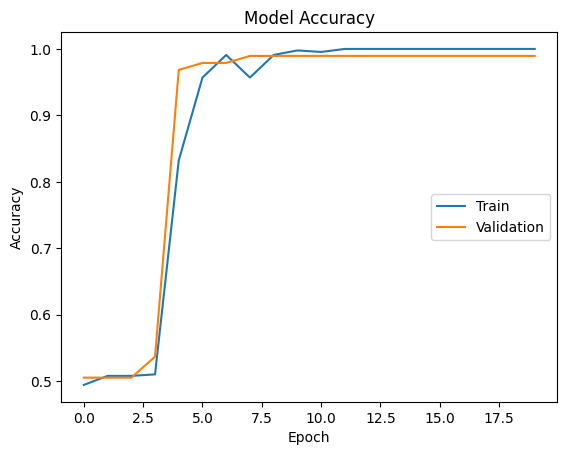

In [20]:
# Plotting Model Accuracy - Train & Validationplot_model_accuracy(history_1)

### Train Performance

In [24]:
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train)print("Train performance metrics")print(model_1_train_perf)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


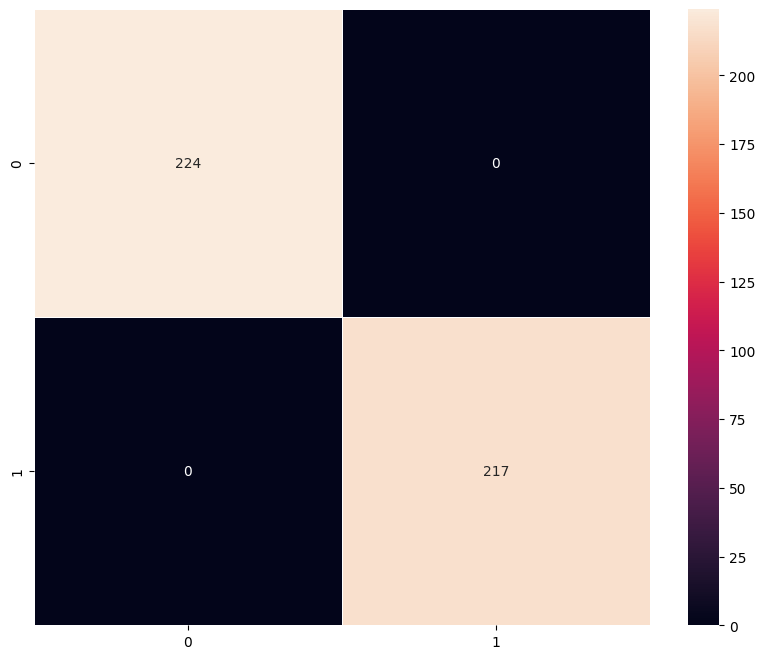

In [25]:
plot_confusion_matrix(model_1,X_train_normalized,y_train)

### Test Performance

In [26]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val)print("Validation performance metrics")print(model_1_valid_perf)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.989474  0.989474   0.989693  0.989474


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


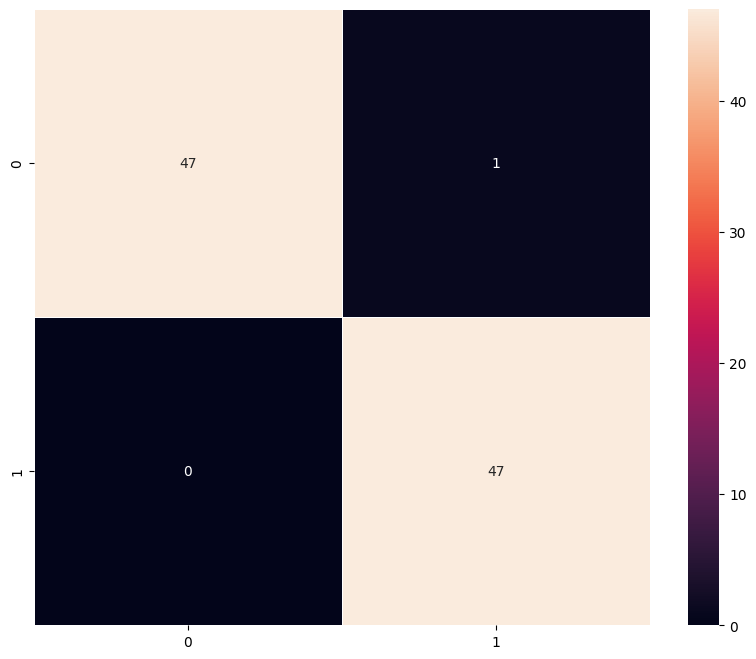

In [28]:
plot_confusion_matrix(model_1,X_val_normalized,y_val)

### Vizualizing Prediction


--- Random Image 1 (Index: 70) ---


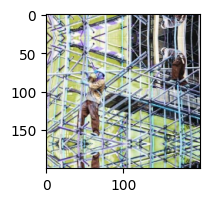

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: 1
True Label: Label    1
Name: 94, dtype: int64

--- Random Image 2 (Index: 19) ---


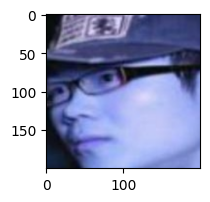

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted: 0
True Label: Label    0
Name: 427, dtype: int64


In [35]:
# Displaying Model Prediction with Random Imagesdisplay_random_predictions(model_1)

### Insights

- The simple CNN on training data set is always perfect (1), however in testing dataset there is a slight reduction across the board for metrics like accuracy, precision, etc- Slight reduction between training and test datasets suggests slight overfitting, but very minimal

## **Model 2: (VGG-16 (Base))**

### Loading Model & Freezing Layers

In [21]:
# Loading Pre-trained VGG16 Model - Feature Extraction Basevgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))# Displaying Model Summaryvgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Freezing VGG16 Layers - Preventing Weight Updates During Trainingfor layer in vgg_model.layers:    layer.trainable = False

### Initializing Model

In [23]:
# Initializing Modelmodel_2 = Sequential()# Transfer Learning - Adding Pre-trained VGG16 Feature Extractormodel_2.add(vgg_model)# Flattening the output of the VGG16 model because it is from a convolutional layermodel_2.add(Flatten())# Classification - Flatten and Dense Layersmodel_2.add(Dense(1, activation='sigmoid')) # Model Compilation - Optimizer & Loss Functionopt = Adam(learning_rate=0.001)model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [24]:
# Displaying Model Summarymodel_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# Data Generator - Original Imagestrain_datagen = ImageDataGenerator()

In [26]:
# Fixed Epochs & Batchesepochs = 20 batch_size = 64 # Runing Modelhistory_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train,                                      batch_size=batch_size,                                      seed=42,                                      shuffle=False),                    epochs=epochs,                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,                    validation_data=(X_val_normalized,y_val),                    verbose=1)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6718 - loss: 0.5934 - val_accuracy: 1.0000 - val_loss: 0.1234
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 824ms/step - accuracy: 0.9844 - loss: 0.1233 - val_accuracy: 1.0000 - val_loss: 0.0759
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 1.0000 - loss: 0.0434 - val_accuracy: 0.9789 - val_loss: 0.0455
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 846ms/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 0.9789 - val_loss: 0.0421
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 0.9895 - val_loss: 0.0216
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 823ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9895 - val_loss: 0.0193
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 870ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0110


### Model Accuracy

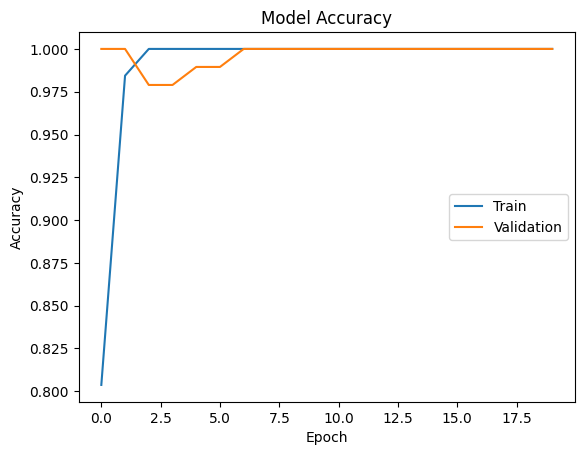

In [27]:
# Plotting Model Accuracy - Train & Validationplot_model_accuracy(history_2)

### Train Performance

In [44]:
model_2_train_perf = model_performance_classification(model_2,X_train_normalized,y_train)print("Train performance metrics")print(model_2_train_perf)

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


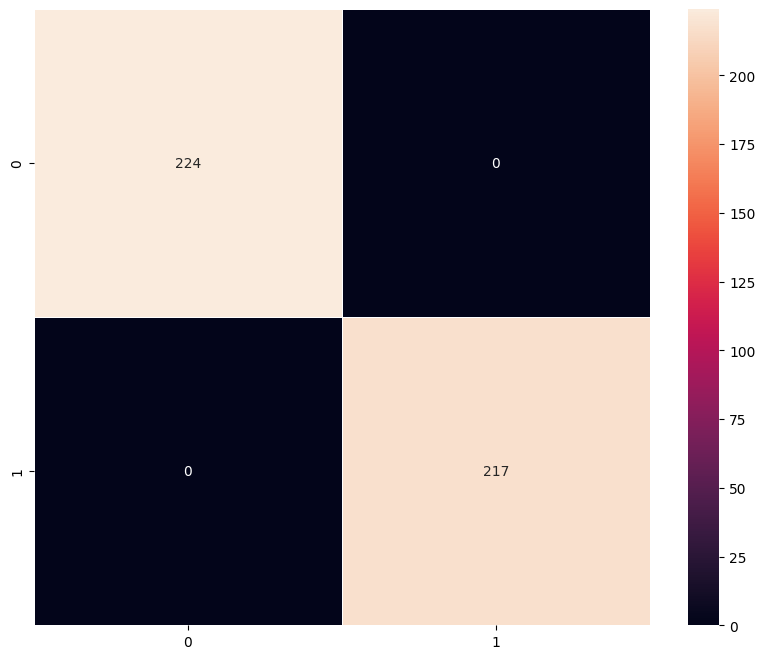

In [45]:
plot_confusion_matrix(model_2,X_train_normalized,y_train)

### Test Performance

In [46]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val)print("Validation performance metrics")print(model_2_valid_perf)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


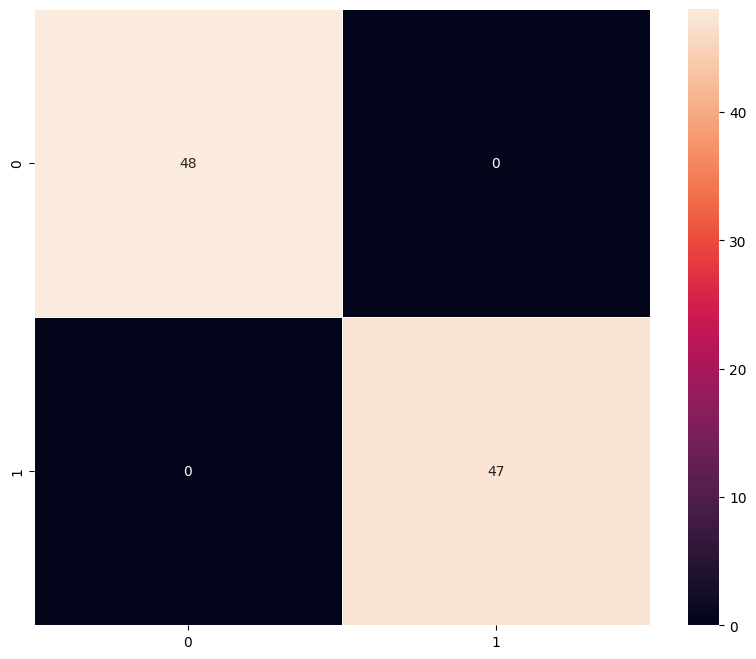

In [47]:
plot_confusion_matrix(model_2,X_val_normalized,y_val)

### Visualizing Prediction


--- Random Image 1 (Index: 65) ---


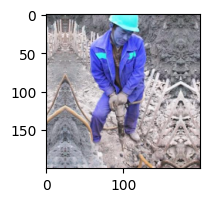

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted: 1
True Label: Label    1
Name: 115, dtype: int64

--- Random Image 2 (Index: 48) ---


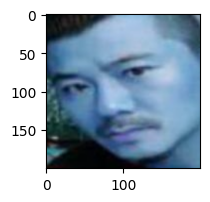

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted: 0
True Label: Label    0
Name: 359, dtype: int64


In [51]:
# Displaying Model Prediction with Random Imagesdisplay_random_predictions(model_2)

### Insights

- Downloading the VGG 16 model and running the images through it to get a baseline of how the model performs- Based on the performance results, by the first epoch, it is basically a perfect model. There is no overfitting - Results for training and validation where all 1 in terms of accuracy, precision, etc

## **Model 3: (VGG-16 (Base + FFNN))**

- Use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will add a Flatten layer and a Feed Forward Neural Network.

### Initializing Model

In [28]:
# Intializing Modelmodel_3 = Sequential()# Transfer Learning - Adding Pre-trained VGG16 Feature Extractormodel_3.add(vgg_model)# Flattening the output of the VGG16 model because it is from a convolutional layermodel_3.add(Flatten())# Classification - Flatten and Dense Layersmodel_3.add(Dense(128,activation='relu')) model_3.add(Dropout(rate=0.5)) model_3.add(Dense(32,activation='relu')) model_3.add(Dense(1, activation='sigmoid'))# Model Compilation - Optimizer & Loss Functionopt = Adam(learning_rate=0.001)model_3.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [29]:
# Displaying Model Summarymodel_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,273 (65.15 MB)

 Trainable params: 2,363,585 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
# Runing Modelhistory_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train,                                       batch_size=64, #Complete the code to define the batch size                                       seed=42,                                       shuffle=False),                    epochs=20, #Complete the code to define the number of epochs                    steps_per_epoch=X_train_normalized.shape[0] // 64,                    validation_data=(X_val_normalized,y_val),                    verbose=1)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9669 - loss: 0.0943 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 887ms/step - accuracy: 0.9844 - loss: 0.0724 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9857 - loss: 0.0495 - val_accuracy: 1.0000 - val_loss: 8.7586e-04
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 858ms/step - accuracy: 1.0000 - loss: 1.4877e-04 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9895 - val_loss: 0.0124
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 818ms/step - accuracy: 1.0000 - loss: 4.8673e-04 - val_accuracy: 0.9895 - val_loss: 0.0129
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 815ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_l

### Model Accuracy

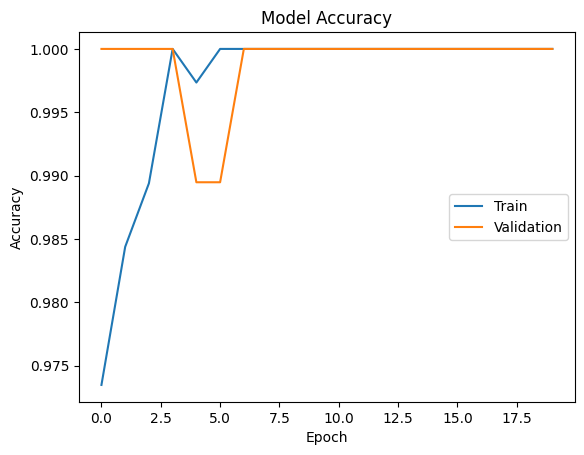

In [32]:
plot_model_accuracy(history_3)

### Train Performance

In [57]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train)print("Train performance metrics")print(model_3_train_perf)

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


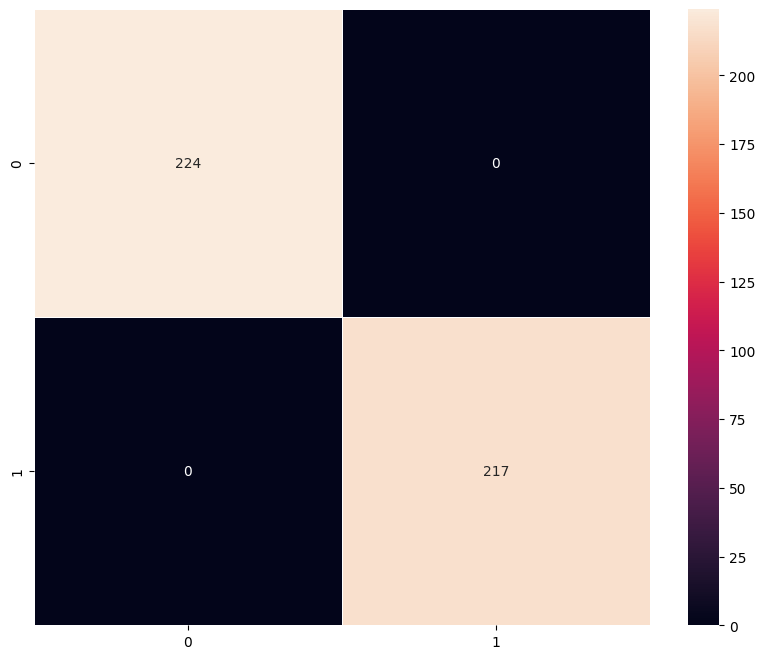

In [58]:
plot_confusion_matrix(model_3,X_train_normalized,y_train)

### Test Performance

In [59]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val)print("Validation performance metrics")print(model_3_valid_perf)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


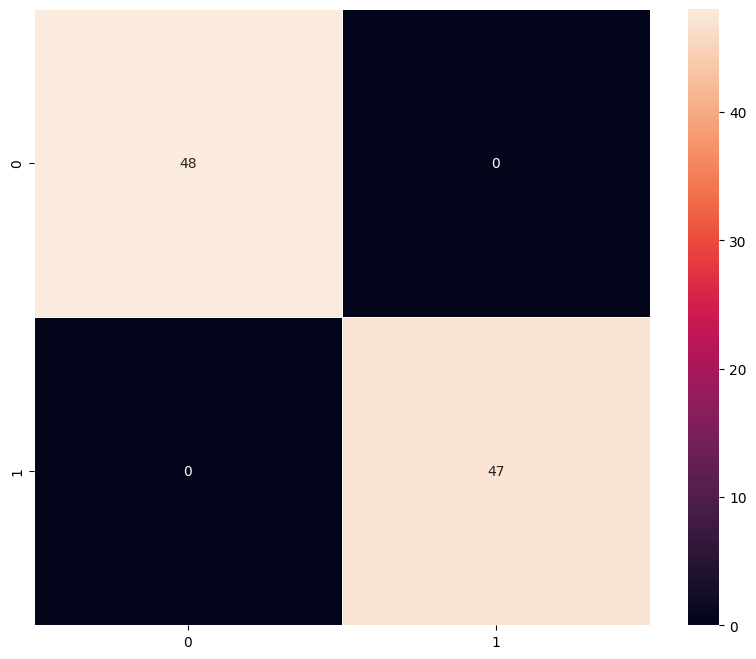

In [60]:
plot_confusion_matrix(model_3,X_val_normalized,y_val)

### Visualizing Predictions


--- Random Image 1 (Index: 57) ---


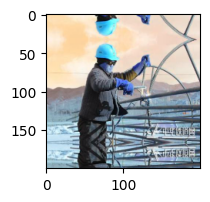

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted: 1
True Label: Label    1
Name: 105, dtype: int64

--- Random Image 2 (Index: 71) ---


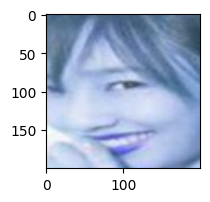

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted: 0
True Label: Label    0
Name: 362, dtype: int64


In [64]:
display_random_predictions(model_3)

### Insights

- Model performs execellent, just as the base moddel (VGG 16)- By epoch 3 all performance is perfect and no overfitting like model 1- Metrics like accuracy, precision, etc are perfect in both training and validation datasets 

## **Model 4: (VGG-16 (Base + FFNN + Data Augmentation)**

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.- To overcome this problem, one approach we might consider is **Data Augmentation**.- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below    -  Horizontal Flip (should be set to True/False)    -  Vertical Flip (should be set to True/False)    -  Height Shift (should be between 0 and 1)    -  Width Shift (should be between 0 and 1)    -  Rotation (should be between 0 and 180)    -  Shear (should be between 0 and 1)    -  Zoom (should be between 0 and 1) etc.Remember, **data augmentation should not be used in the validation/test data set**.

### Initilaizing Model

In [74]:
# Initializing Modelmodel_4 = Sequential()# Transfer Learning - Adding Pre-trained VGG16 Feature Extractormodel_4.add(vgg_model)# Flattening the output of the VGG16 model because it is from a convolutional layermodel_4.add(Flatten())# Classification - Flatten and Dense Layersmodel_4.add(Dense(128,activation='relu')) model_4.add(Dropout(rate=0.5)) model_4.add(Dense(32,activation='relu')) model_4.add(Dense(1, activation='sigmoid')) # Model Compilation - Optimizer & Loss Functionopt=Adam(learning_rate=0.001)model_4.compile(optimizer=opt,   loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [75]:
# Displaying Model Summarymodel_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,273 (65.15 MB)

 Trainable params: 2,363,585 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [76]:
# Applying Data Augmentation - Rotating Imagestrain_datagen = ImageDataGenerator(                              rotation_range=20,                              fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2                              ) 

In [77]:
# Runing Model with Augmentationhistory_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,                                       batch_size=32,                                        seed=42,                                       shuffle=False),                    epochs=epochs,                    steps_per_epoch=X_train_normalized.shape[0] // 32,                    validation_data=(X_val_normalized,y_val),                    verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6451 - loss: 0.6527 - val_accuracy: 0.9789 - val_loss: 0.0221
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - accuracy: 0.9688 - loss: 0.1581 - val_accuracy: 0.9895 - val_loss: 0.0134
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9647 - loss: 0.0690 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9947 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 4.6967e-04
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 1.0000 - loss: 3.6741e-04 - val_accuracy: 1.0000 - val_loss: 4.2464e-04
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9956 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 4.7969e-04
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accu

### Model Accuracy

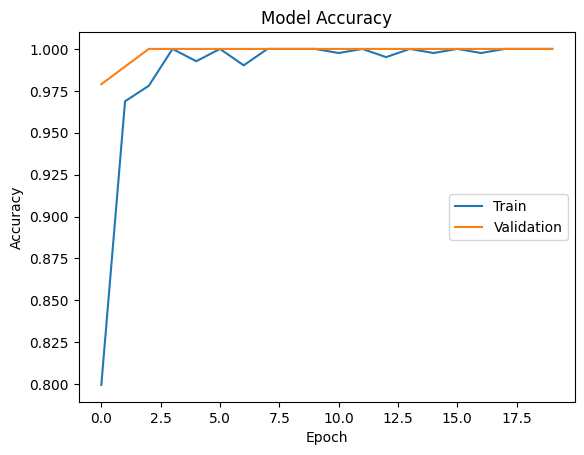

In [78]:
plot_model_accuracy(history_4)

### Train Performance

In [ ]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized, y_train)print("Train performance metrics")print(model_4_train_perf)

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


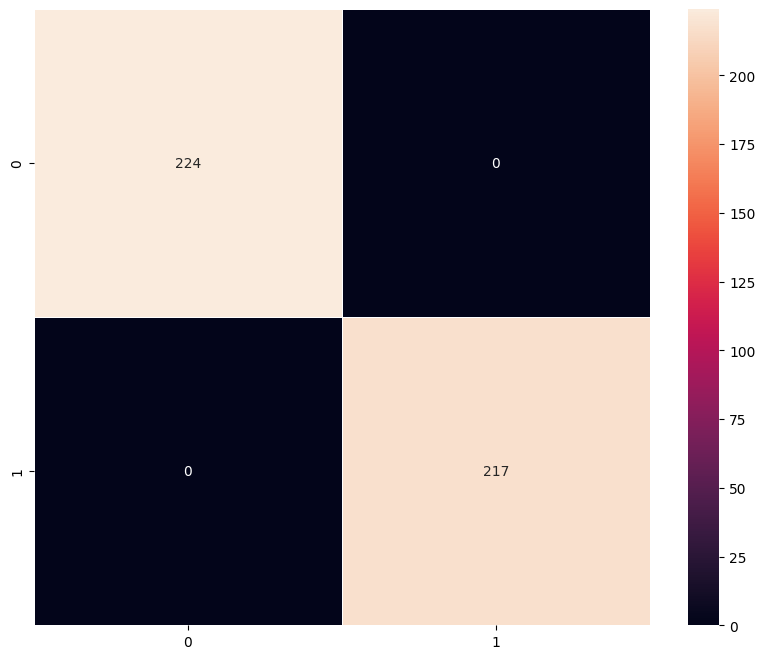

In [80]:
plot_confusion_matrix(model_4, X_train_normalized, y_train)

### Test Performance

In [81]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized, y_val)print("Validation performance metrics")print(model_4_valid_perf)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


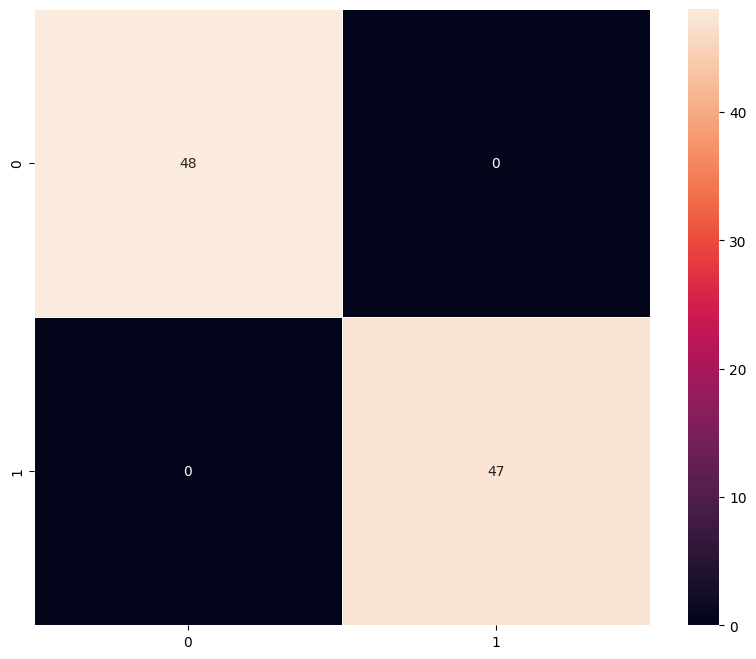

In [82]:
plot_confusion_matrix(model_4, X_val_normalized, y_val)

### Visualizing Predictions


--- Random Image 1 (Index: 83) ---


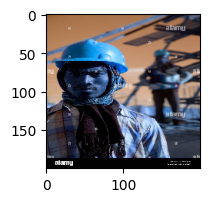

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted: 1
True Label: Label    1
Name: 102, dtype: int64

--- Random Image 2 (Index: 80) ---


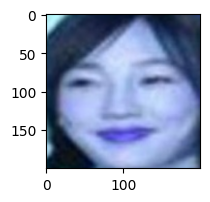

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted: 0
True Label: Label    0
Name: 311, dtype: int64


In [83]:
display_random_predictions(model_4)

### Insights

- Model performs execellent, just as the VGG + FNN moddel and the VGG 16- By epoch 6 all performance is perfect and no overfitting like model 1 (there is some fluctuation between epoches 3-6)- Metrics like accuracy, precision, etc are perfect in both training and validation datasets

## **Model Performance Comparison and Final Model Selection**

### Setting Up Comparisons

In [75]:
# training performance comparisonmodels_train_comp_df = pd.concat(    [        model_1_train_perf.T,        model_2_train_perf.T,        model_3_train_perf.T,        model_4_train_perf.T,    ],    axis=1,)models_train_comp_df.columns = [    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"]

In [ ]:
# validation performance comparisonmodels_valid_comp_df = pd.concat(    [        model_1_valid_perf.T,        model_2_valid_perf.T,        model_3_valid_perf.T,        model_4_valid_perf.T    ],    axis=1,)models_valid_comp_df.columns = [ "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"]

### Comparison Results

In [77]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [78]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.989474,1.0,1.0,1.0
Recall,0.989474,1.0,1.0,1.0
Precision,0.989693,1.0,1.0,1.0
F1 Score,0.989474,1.0,1.0,1.0


In [79]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.010526,0.0,0.0,0.0
Recall,0.010526,0.0,0.0,0.0
Precision,0.010307,0.0,0.0,0.0
F1 Score,0.010526,0.0,0.0,0.0


### Test Performance

In [ ]:
model_test_perf = model_performance_classification(model_4, X_test_normalized, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [81]:
model_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


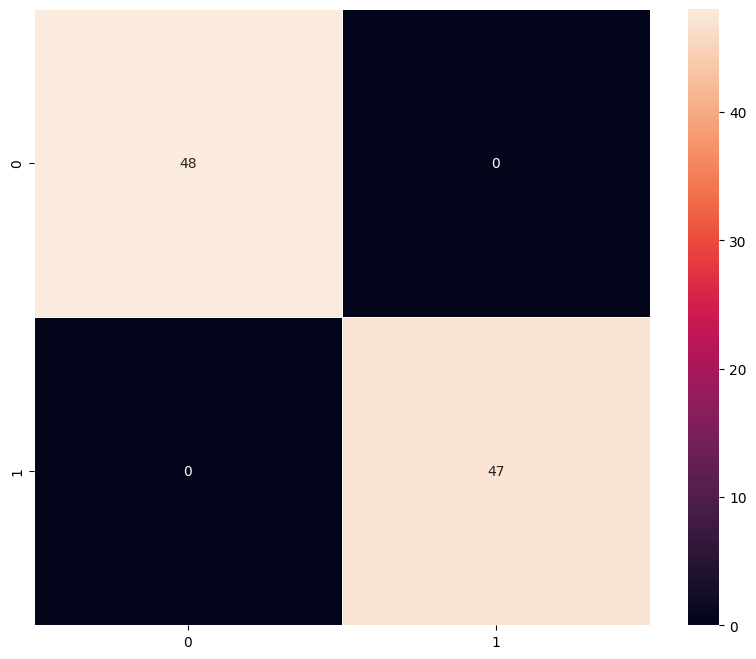

In [ ]:
plot_confusion_matrix(model_4, X_test_normalized, y_test)

### **Actionable Insights & Model Recommendations**- The best-performing models are VGG16 Base, VGG16 + FNN, and VGG16 + FFNN + Data Augmentation. They all achieve high accuracy and recall, making it suitable for real-world helmet detection.- The models generalize well, as indicated by similar performance on training and test sets.**Recommendations:**- Deploy the model as part of an automated monitoring system to detect helmet compliance in real time.- Integrate with an alert system to notify supervisors of non-compliance immediately to prevent accidents- Use detection logs for compliance reporting and to identify high-risk areas or times- Continuously collect and label new data to further improve model performance, especially for edge cases.**Business Impact:**- Improved worker safety and reduced risk of head injuries.- Cost savings from reduced manual monitoring and less prone to errors than when maually monitoring- Enhanced compliance with safety regulations, reducing legal and financial risks.

<font size=5 color='blue'>Power Ahead!</font>___